<a href="https://colab.research.google.com/github/unique-subedi/fourier-linear-operators/blob/main/fourier_linear_operators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.sparse.linalg import spsolve
from scipy.fftpack import dctn
from scipy.fftpack import idctn
import numpy as np
from scipy.fftpack import idctn
import numpy as np
from scipy.sparse import diags, eye, kron
from scipy.fft import fftn, ifftn
from scipy.sparse.linalg import inv, spsolve
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Data Generation

In [ ]:
def GRF(alpha, beta, gamma, N):
    xi = np.random.randn(N, N)
    K1, K2 = np.meshgrid(np.arange(N), np.arange(N))
    coef = alpha**(1/2) *(4*np.pi**2 * (K1**2 + K2**2) + beta)**(-gamma / 2)
    L = N * coef * xi
    L[0, 0] = 0
    f =idctn(L, type =2)
    return f



def get_grf_datasets(
    N: int,
    alpha: float,
    beta: float,
    gamma: float,
    n_train: int = 2048,
    n_test: int = 128,
    batch_size: int = 32,
    device: str = 'cpu'
):
    rng_w = np.random.RandomState(SEED)
    W     = 10 * rng_w.rand(N, N) - 5

    def _make_dataset(n_samples):
        X_list, Y_list = [], []
        for _ in range(n_samples):
            f = GRF(alpha, beta, gamma, N)
            u = fftn(f, norm='forward')
            u = ifftn(W * u, norm='forward').real + GRF(1.0, beta, 1.5*gamma, N)
            X_list.append(f.astype(np.float32))
            Y_list.append(u.astype(np.float32))
        X_arr = np.stack(X_list)
        Y_arr = np.stack(Y_list)
        X_t = torch.from_numpy(X_arr).to(device)
        Y_t = torch.from_numpy(Y_arr).to(device)
        return X_t, Y_t

    X_train, Y_train = _make_dataset(n_train)
    X_test, Y_test   = _make_dataset(n_test)


    return X_train, Y_train, X_test, Y_test



class LinearModel(nn.Module):
    def __init__(self, N: int, trunc_mode: int, device='cpu'):
        super().__init__()
        self.N = N
        self.trunc_mode = trunc_mode


        self.weight = nn.Parameter(0.1*torch.randn(N, N))



        k = torch.fft.fftfreq(N) * N
        kx, ky = torch.meshgrid(k, k, indexing='ij')
        mask = (kx.abs() <= trunc_mode) & (ky.abs() <= trunc_mode)
        self.register_buffer('mask', mask)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        X_hat = torch.fft.fftn(x, norm='forward', dim=(-2, -1))
        W     = self.weight * self.mask
        Y_hat = X_hat * W
        y     = torch.fft.ifftn(Y_hat, norm='forward', dim=(-2, -1)).real
        return y



class RelativeMeanSquaredErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(RelativeMeanSquaredErrorLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        squared_errors = torch.square(predictions - targets)
        mse = torch.mean(squared_errors, dim=(-2, -1))
        target_mse = torch.mean(torch.square(targets), dim=(-2, -1))
        relative_mse = mse / (target_mse + self.epsilon)
        return torch.mean(relative_mse)

# Statistical Error

In [ ]:
# sample_sizes = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
sample_sizes = [16, 32, 64, 128, 256, 512, 1024]
gammas = [1.5,2,2.5,3]
test_losses=[]
for g in gammas:
    print(f"\n=== Gamma = {g} ===")
    test_losses_g = []
    N=128
    X_train, Y_train, X_test, Y_test = get_grf_datasets(
      N, alpha=1e2, beta=1, gamma=g,
        n_train=1024, n_test=128,
        batch_size=32, device=device
    )
    for sample_size in sample_sizes:
        idx = torch.randperm(X_train.size(0), device=device)[:sample_size]
        subset_X = X_train[idx]
        subset_Y = Y_train[idx]
        train_subset = TensorDataset(subset_X, subset_Y)
        subset_loader = DataLoader(train_subset, batch_size=min(32, sample_size), shuffle=True)
        truncmode=N//2
        model = LinearModel(N, truncmode).to(device)
        criterion = RelativeMeanSquaredErrorLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 200
        for epoch in range(num_epochs):
            for batch_X, batch_Y in subset_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y) # Take the mean of the batch losses
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            total_loss = 0
            test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=32, shuffle=True)
            for batch_X, batch_Y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y).mean()
                total_loss += loss.item() * batch_X.size(0)
            average_loss = total_loss / 128
            test_losses_g.append(average_loss)
            print(f"Sample size: {sample_size}, Test loss: {average_loss}")

    test_losses.append(test_losses_g)





=== Gamma = 1.5 ===
Sample size: 16, Test loss: 0.82605841755867
Sample size: 32, Test loss: 0.8175179958343506
Sample size: 64, Test loss: 0.6556525528430939
Sample size: 128, Test loss: 0.4455967918038368
Sample size: 256, Test loss: 0.19777923822402954
Sample size: 512, Test loss: 0.030579078942537308
Sample size: 1024, Test loss: 0.0004263077353243716

=== Gamma = 2 ===
Sample size: 16, Test loss: 0.8024049699306488
Sample size: 32, Test loss: 0.7920302152633667
Sample size: 64, Test loss: 0.6937597990036011
Sample size: 128, Test loss: 0.4345863536000252
Sample size: 256, Test loss: 0.17518754675984383
Sample size: 512, Test loss: 0.027840611524879932
Sample size: 1024, Test loss: 0.0002694621798582375

=== Gamma = 2.5 ===
Sample size: 16, Test loss: 0.7782664895057678
Sample size: 32, Test loss: 0.8020915985107422
Sample size: 64, Test loss: 0.6122258901596069
Sample size: 128, Test loss: 0.4011506885290146
Sample size: 256, Test loss: 0.17222261801362038
Sample size: 512, Test 

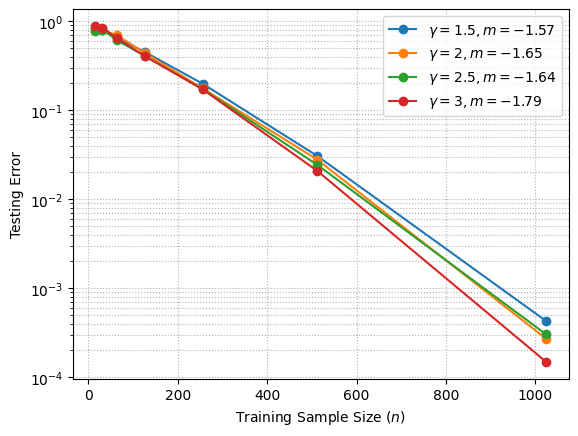

In [ ]:
from matplotlib.ticker import LogFormatterMathtext
plt.figure()
ax = plt.gca()

for losses, g in zip(test_losses, gammas):
    losses = np.array(losses)
    slope, intercept = np.polyfit(np.log(sample_sizes), np.log(losses), 1)


    ax.plot(sample_sizes, losses, 'o-',
            label=fr'$\gamma={g}, m={slope:.2f}$')


ax.set_yscale('log')


formatter = LogFormatterMathtext(base=10)
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_minor_formatter(formatter)

ax.set_xlabel("Training Sample Size $(n)$")
ax.set_ylabel("Testing Error")
ax.legend()
ax.grid(which='both', linestyle=':')
plt.savefig('statistical_new.png')
plt.show()

# Truncation Error

In [ ]:
gammas = [1.5,2,2.5,3]

truncmodes = [8, 16,32,40,48, 56, 60,64]

num_epochs    = 200
batch_size    = 32
lr            = 1e-3
N             = 128
input_size    = N
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_losses_truncmodes = []

for g in gammas:
    print(f"\n=== Gamma = {g} ===")

    X_train, Y_train, X_test, Y_test = get_grf_datasets(
        N, alpha=1e2, beta=1, gamma=g,
        n_train=1024, n_test=128,
        batch_size=batch_size, device=device
    )


    train_loader = DataLoader(
        TensorDataset(X_train, Y_train),
        batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(X_test, Y_test),
        batch_size=batch_size, shuffle=False
    )

    losses_for_g = []
    for K in truncmodes:
        model     = LinearModel(input_size, K).to(device)
        criterion = RelativeMeanSquaredErrorLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)


        model.train()
        for _ in range(num_epochs):
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()


        model.eval()
        total = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                total += criterion(model(xb), yb).item() * xb.size(0)
        avg_loss = total / len(test_loader.dataset)
        losses_for_g.append(avg_loss)
        print(f"K={K:2d}   loss={avg_loss:.4f}")

    test_losses_truncmodes.append(losses_for_g)






=== Gamma = 1.5 ===
K= 8 → loss=0.1322
K=16 → loss=0.0642
K=32 → loss=0.0273
K=40 → loss=0.0171
K=48 → loss=0.0101
K=56 → loss=0.0050
K=60 → loss=0.0026
K=64 → loss=0.0004

=== Gamma = 2 ===
K= 8 → loss=0.0834
K=16 → loss=0.0430
K=32 → loss=0.0204
K=40 → loss=0.0131
K=48 → loss=0.0079
K=56 → loss=0.0044
K=60 → loss=0.0020
K=64 → loss=0.0003

=== Gamma = 2.5 ===
K= 8 → loss=0.0793
K=16 → loss=0.0417
K=32 → loss=0.0199
K=40 → loss=0.0128
K=48 → loss=0.0077
K=56 → loss=0.0043
K=60 → loss=0.0020
K=64 → loss=0.0002

=== Gamma = 3 ===
K= 8 → loss=0.0855
K=16 → loss=0.0468
K=32 → loss=0.0235
K=40 → loss=0.0154
K=48 → loss=0.0091
K=56 → loss=0.0051
K=60 → loss=0.0020
K=64 → loss=0.0002


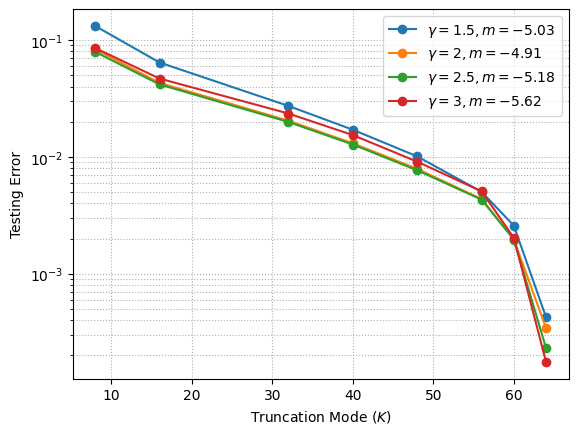

In [ ]:
plt.figure()
ax = plt.gca()

for losses, g in zip(test_losses_truncmodes, gammas):
    losses = np.array(losses)
    # fit slope on log–log
    slope, _ = np.polyfit(np.log(truncmodes[2:]), np.log(losses[2:]), 1)
    ax.plot(truncmodes, losses, 'o-',
            label=fr'$\gamma={g},m={slope:.2f}$')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))

ax.set_xlabel("Truncation Mode ($K$)")
ax.set_ylabel("Testing Error")
ax.legend()
ax.grid(which='both', linestyle=':')
plt.savefig('truncation_new.png')
plt.show()

# Discretization

In [ ]:
import numpy as np, torch, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterMathtext


def coarser_grid_data(data, M):
    N = data.shape[0]
    if N % M != 0:
        raise ValueError("N must be divisible by M.")
    step_size = N // M
    return data[::step_size, ::step_size]

def run_discretization(gammas, gridsizes, N, device):
    results = {}
    for g in gammas:
        print(f"\n=== Gamma = {g} ===")
        Xtr, Ytr, Xte, Yte = get_grf_datasets(
            N, alpha=1e2, beta=1, gamma=g,
            n_train=1024, n_test=128,
            device=device
        )


        trainset = [{'x': Xtr[i].cpu().numpy().reshape(N, N),
                     'y': Ytr[i].cpu().numpy().reshape(N, N)}
                    for i in range(len(Xtr))]
        testset  = [{'x': Xte[i].cpu().numpy().reshape(N, N),
                     'y': Yte[i].cpu().numpy().reshape(N, N)}
                    for i in range(len(Xte))]

        losses = []
        for M in gridsizes:
            X_train = torch.stack([
                torch.tensor(coarser_grid_data(dp['x'], M), dtype=torch.float32)
                for dp in trainset]).to(device)
            Y_train = torch.stack([
                torch.tensor(coarser_grid_data(dp['y'], M), dtype=torch.float32)
                for dp in trainset]).to(device)
            train_ds = TensorDataset(X_train, Y_train)


            truncmode = M // 2
            model = LinearModel(M, truncmode).to(device)
            criterion = RelativeMeanSquaredErrorLoss().to(device)
            opt = optim.Adam(model.parameters(), lr=1e-3)

            loader = DataLoader(train_ds, batch_size=32, shuffle=True)
            for _ in range(200):
                for xb, yb in loader:
                    opt.zero_grad()
                    loss = criterion(model(xb), yb)
                    loss.backward(); opt.step()


            with torch.no_grad():
                total = 0
                w = model.weight.detach() * model.mask.detach()
                Wexp = torch.zeros((N, N), device=device)
                Wexp[:M, :M]   = w
                Wexp[:M, -M:]  = w
                Wexp[-M:, :M]  = w
                Wexp[-M:, -M:] = w

                for dp in testset:
                    x = torch.tensor(dp['x'], dtype=torch.float32).to(device)
                    y = torch.tensor(dp['y'], dtype=torch.float32).to(device)
                    y_hat = torch.fft.ifftn(Wexp * torch.fft.fftn(x, norm='forward'),
                                            norm='forward').real
                    total += torch.square(y - y_hat).mean()/(torch.square(y).mean() + 1e-8)

                avg = total / len(testset)
                losses.append(avg.cpu().item())
                print(f"  M={M:3d}  loss={avg:.4e}")

        results[g] = np.array(losses)
    return results

gammas    = [1.5, 2, 2.5, 3]
gridsizes = [2**i for i in range(1, 9)]
N         = 2**9
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

res = run_discretization(gammas, gridsizes, N, device)




=== Gamma = 1.5 ===
  M=  2  loss=9.4588e-01
  M=  4  loss=7.1545e-01
  M=  8  loss=3.4751e-01
  M= 16  loss=1.5702e-01
  M= 32  loss=8.0139e-02
  M= 64  loss=3.9517e-02
  M=128  loss=1.8083e-02
  M=256  loss=6.8150e-03

=== Gamma = 2 ===
  M=  2  loss=1.0091e+00
  M=  4  loss=6.4658e-01
  M=  8  loss=3.1566e-01
  M= 16  loss=1.3711e-01
  M= 32  loss=7.2204e-02
  M= 64  loss=3.4218e-02
  M=128  loss=1.5476e-02
  M=256  loss=5.5599e-03

=== Gamma = 2.5 ===
  M=  2  loss=1.0072e+00
  M=  4  loss=6.5119e-01
  M=  8  loss=3.2381e-01
  M= 16  loss=1.4613e-01
  M= 32  loss=7.6987e-02
  M= 64  loss=3.6384e-02
  M=128  loss=1.6299e-02
  M=256  loss=5.7510e-03

=== Gamma = 3 ===
  M=  2  loss=1.0757e+00
  M=  4  loss=6.7679e-01
  M=  8  loss=3.4243e-01
  M= 16  loss=1.5516e-01
  M= 32  loss=8.1579e-02
  M= 64  loss=3.8505e-02
  M=128  loss=1.7228e-02
  M=256  loss=6.0451e-03


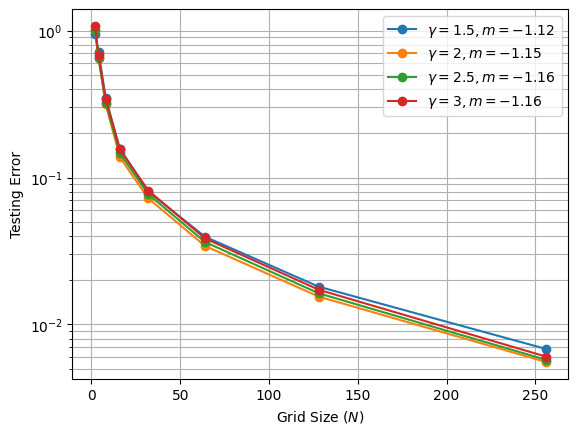

In [ ]:
def plot_discretization(results, gridsizes, outfile='discretization_new.png'):
    plt.figure(); ax = plt.gca()
    for g, losses in results.items():
        slope, _ = np.polyfit(np.log(gridsizes[3:]), np.log(losses[3:]), 1)
        ax.plot(gridsizes, losses, 'o-',
                label=rf'$\gamma={g},m={slope:.2f}$')
    ax.set_yscale('log'); ax.set_xscale('linear')
    ax.set_xlabel('Grid Size $(N)$'); ax.set_ylabel('Testing Error')
    ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
    ax.yaxis.set_minor_formatter(LogFormatterMathtext(base=10))
    ax.legend(); ax.grid(True, which='both')
    plt.savefig(outfile); plt.show()

plot_discretization(res, gridsizes)